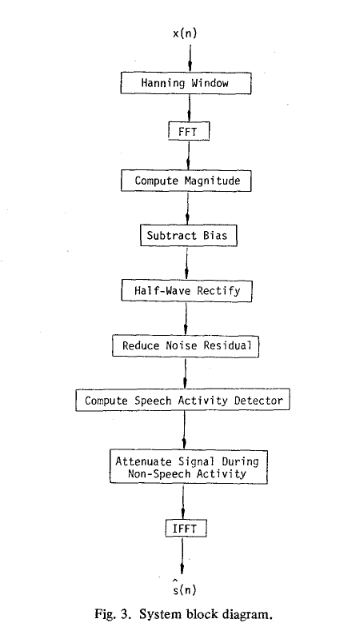

In [137]:
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd

In [146]:
y_full_speech, sr = librosa.load("/mnt/c/Users/62852/Downloads/Haryo.wav", sr=16000)
len(y_full_speech)

182973

In [177]:
def display_spectogram(ffted_speech: np.ndarray):
    """
    Display spectrogram of the given speech
    """
    plt.figure(figsize=(15, 5))
    librosa.display.specshow(
        librosa.amplitude_to_db(ffted_speech, ref=np.max), y_axis="log", x_axis="time"
    )
    plt.colorbar(format="%+2.0f dB")
    plt.title("Log-frequency power spectrogram")
    plt.tight_layout()
    plt.show()


def transform_to_time_domain_from_spectogram(y_spectral: np.ndarray, sr: int, phase: np.ndarray, length: int):
    """
    Transform the given speech to time domain and display the spectrogram
    """
    display_spectogram(y_spectral)
    y_spectral = y_spectral * phase
    time_domain_audio = librosa.istft(
        y_spectral,
        hop_length=256,
        win_length=512,
        window="hann",
        center=True,
        dtype=np.complex64,
        length=len(y_full_speech),
    )
    display(ipd.Audio(time_domain_audio, rate=sr))

In [174]:
# play the audio and display it
print("Full Speech (S + N)")
ipd.display(ipd.Audio(y_full_speech, rate=sr))


Full Speech (S + N)


In [175]:
from librosa import stft
import numpy as np
y_ffted = stft(y_full_speech, n_fft=512, hop_length=256, win_length=512, window='hann', center=True, dtype=np.complex64, pad_mode='reflect')

/tmp/ipykernel_719/3108218778.py:7: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.amplitude_to_db(ffted_speech, ref=np.max), y_axis="log", x_axis="time"


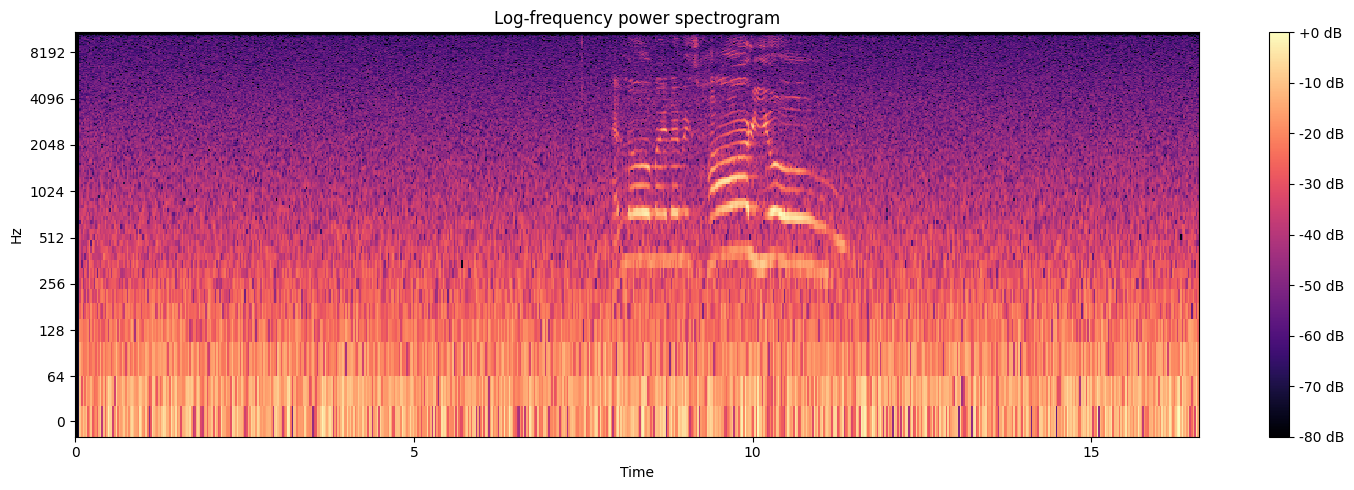

In [176]:
# visualize the spectrogram
display_spectogram(y_ffted)

#### We just take the noise mean based on the time window that we know

In [178]:
# Take the STFT of the noise (0 to 4.5s)
y_noise = y_full_speech[0:int(4.5*sr)]  # 4.5s of noise, just take it based on sampling
y_noise_ffted = stft(y_noise, n_fft=512, hop_length=256, win_length=512, window='hann', center=True, dtype=np.complex64, pad_mode='reflect')

In [179]:
y_noise_ffted.shape

(257, 282)

/tmp/ipykernel_719/3108218778.py:7: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.amplitude_to_db(ffted_speech, ref=np.max), y_axis="log", x_axis="time"


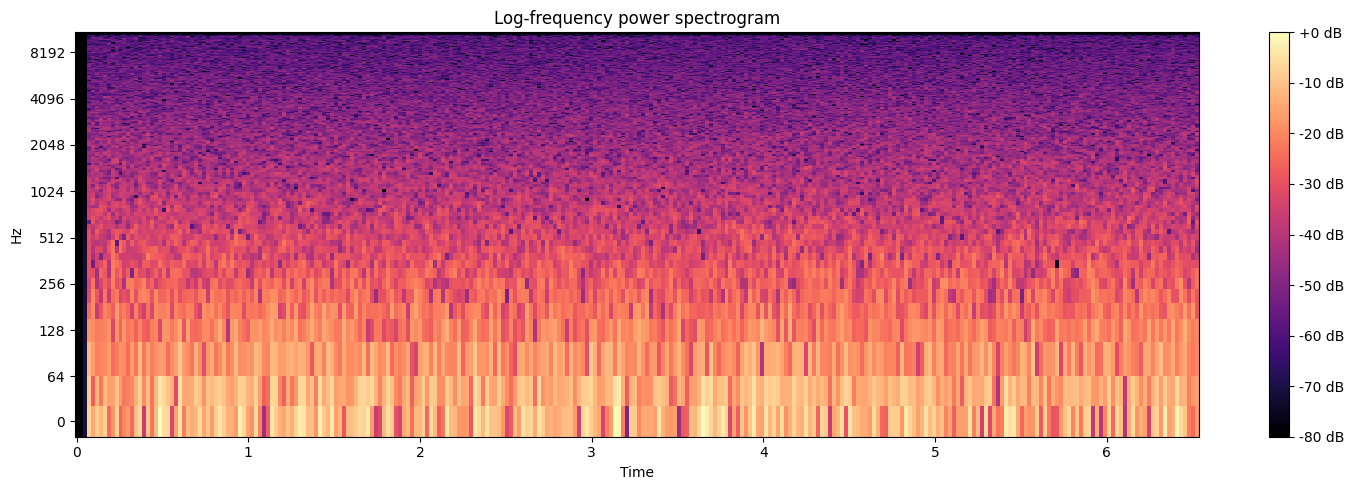

In [180]:
# visualize the spectrogram
display_spectogram(y_noise_ffted)

In [195]:
mean_noise_spectrum = np.mean(np.abs(y_noise_ffted), axis=1, keepdims=True)
mean_noise_spectrum.shape

(257, 1)

#### Spectral Subtraction

In [196]:
# Perform spectral subtraction
S_full_mag = np.abs(y_ffted) - mean_noise_spectrum


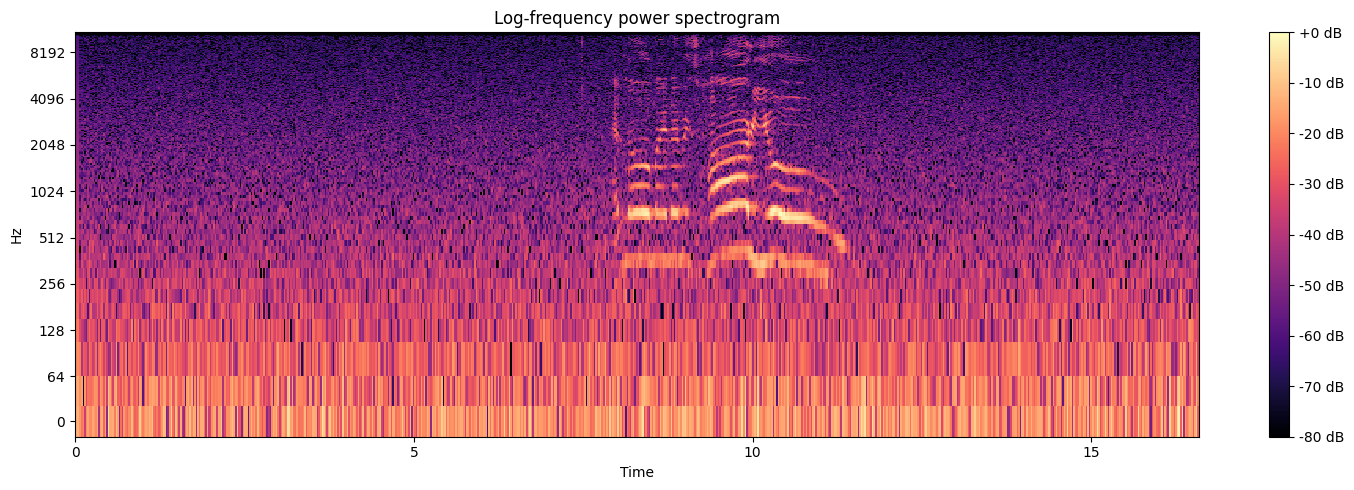

/home/haryoaw/mambaforge/envs/sensei/lib/python3.11/site-packages/IPython/lib/display.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


In [184]:
transform_to_time_domain_from_spectogram(S_full_mag, sr, phase=np.exp(1j * np.angle(y_ffted)), length=len(y_full_speech))

#### Half wave rectification

In [185]:
H = S_full_mag  # H(e^jω) is the result of spectral subtraction
Hr = (H + np.abs(H)) / 2  # Hr(e^jω) as per the provided formula



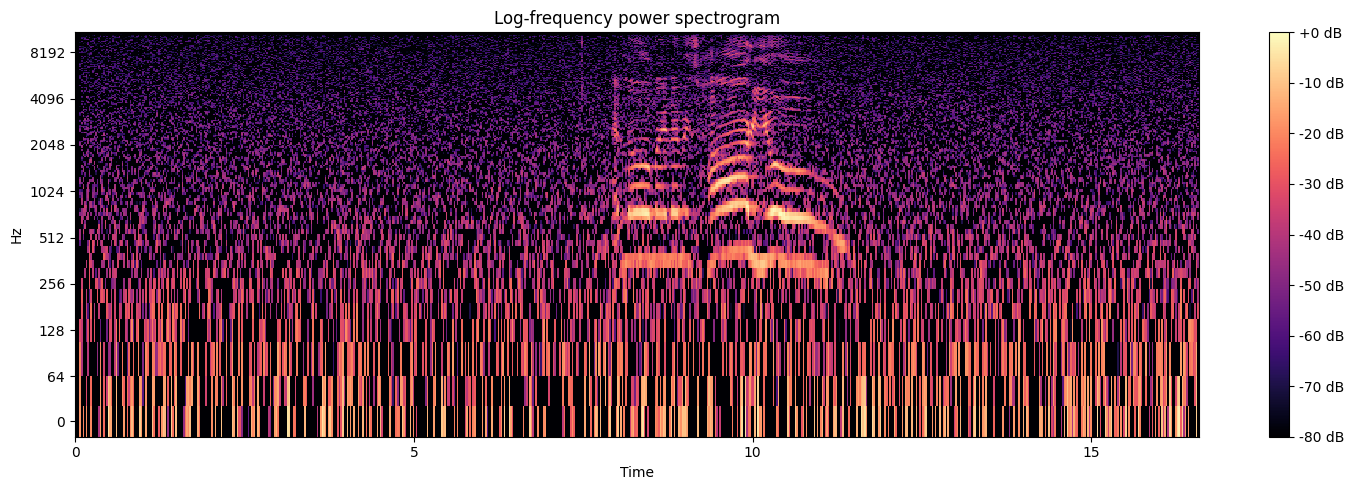

In [187]:
transform_to_time_domain_from_spectogram(Hr, sr, phase=np.exp(1j * np.angle(y_ffted)), length=len(y_full_speech))

### Residual Noise Reduction

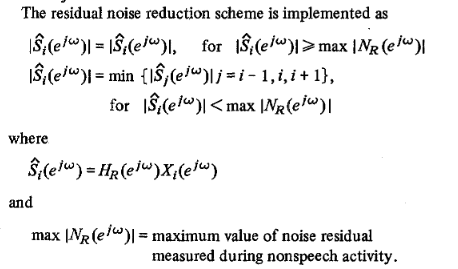



In [192]:
def residual_noise_reduction(S_mag, max_NR):
    # S_mag is the magnitude spectrum after half-wave rectification
    # max_NR is the maximum noise residual calculated during nonspeech activity

    # Initialize the array for the reduced noise spectrum
    S_reduced = np.copy(S_mag)

    # Loop over each frequency bin
    for i in range(1, S_mag.shape[1] - 1):  
        # Apply residual noise reduction by looping the time frames
        for k in range(S_mag.shape[0]):
            if S_mag[k, i] < max_NR[k]:
                S_reduced[k, i] = min(S_mag[k, i-1], S_mag[k, i], S_mag[k, i+1])
    
    return S_reduced

In [193]:
noise_residual = y_noise_ffted - mean_noise_spectrum
# max noise residual per frequency bin
max_noise_residual = np.max(np.abs(noise_residual), axis=1)
S_reduced = residual_noise_reduction(Hr, max_noise_residual)

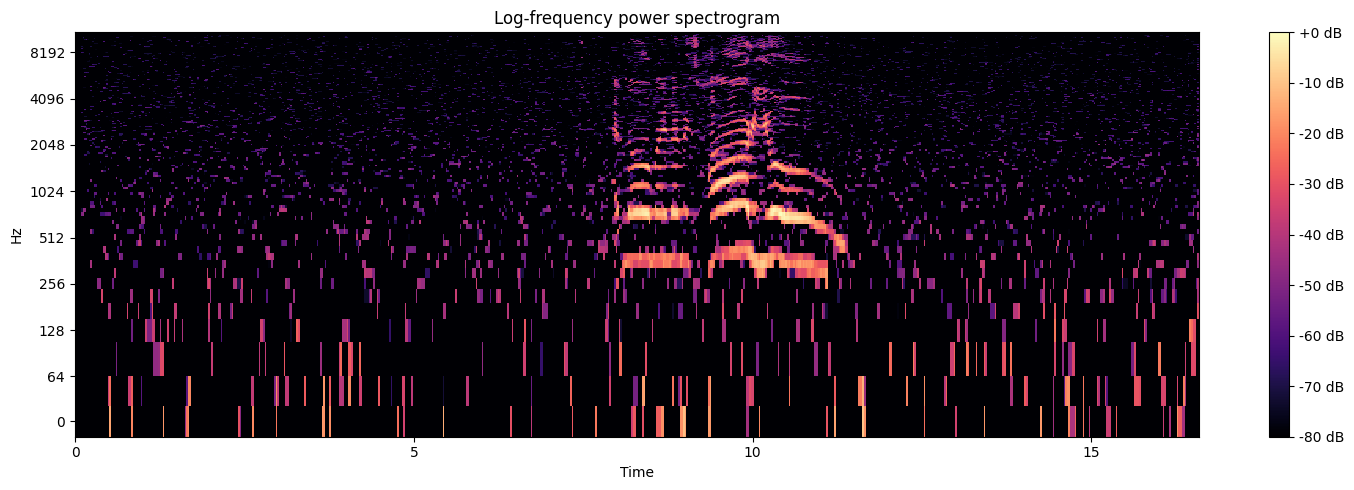

/home/haryoaw/mambaforge/envs/sensei/lib/python3.11/site-packages/IPython/lib/display.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


In [194]:
transform_to_time_domain_from_spectogram(S_reduced, sr, phase=np.exp(1j * np.angle(y_ffted)), length=len(y_full_speech))

## Finally attenuate it

In [228]:
ratio = np.mean(np.abs(S_reduced) / mean_noise_spectrum, axis=1, keepdims=True)

In [229]:
# Calculate T in dB
T = 20 * np.log10(ratio)

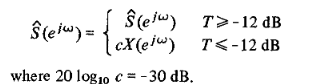

In [230]:
attenuation_dB = -30

In [231]:
c = 10**(attenuation_dB / 20)

In [232]:
S_hat_attenuated = np.where(T > -12, S_reduced, S_reduced * c)

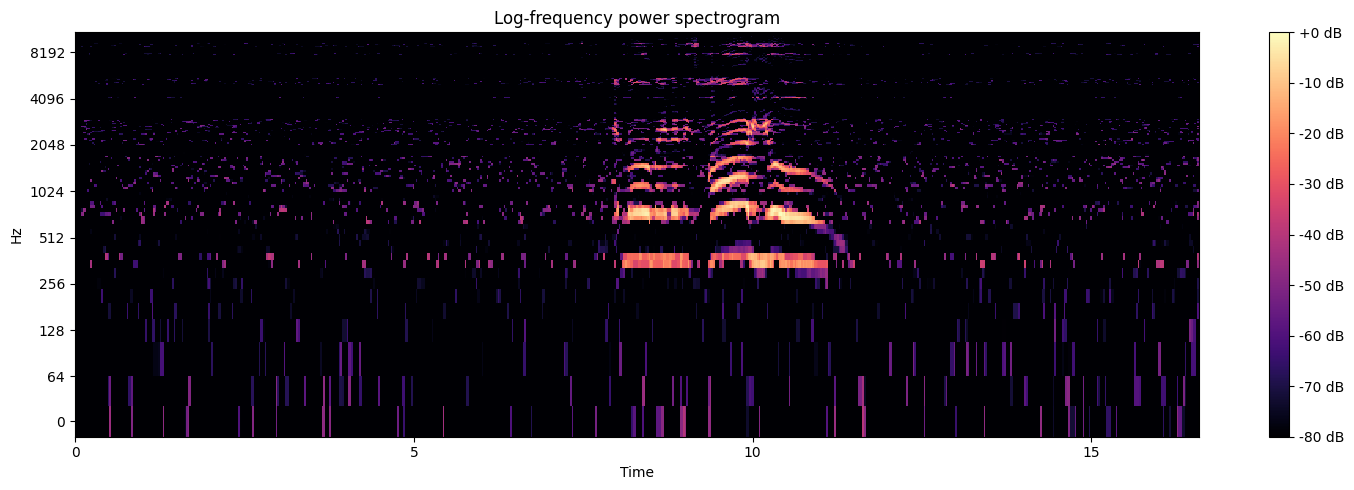

/home/haryoaw/mambaforge/envs/sensei/lib/python3.11/site-packages/IPython/lib/display.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


In [234]:
transform_to_time_domain_from_spectogram(S_hat_attenuated, sr, phase=np.exp(1j * np.angle(y_ffted)), length=len(y_full_speech))